In [ ]:
!pip install -q wandb

In [ ]:
!pip install -q retina-face

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 as cv
from tqdm import tqdm

from keras.models import Sequential, load_model
from keras import layers
from keras.activations import relu, linear
from keras.optimizers import Adam
from keras import losses
from keras.applications import RegNetX032, MobileNetV2, NASNetMobile, Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.src.callbacks import History, EarlyStopping, ModelCheckpoint

from retinaface import RetinaFace

In [ ]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

run = wandb.init(project='Age Detector')

config = wandb.config

wandb_callbacks = [
   WandbMetricsLogger(log_freq=5),
   WandbModelCheckpoint('models'),
]

wandb: Currently logged in as: matin-ghorbani. Use `wandb login --relogin` to force relogin


In [ ]:
DATASET_PATH: str = '/content/UTKFace'
INPUT_SHAPE: tuple[int, int, int] = (124, 124, 3)
EPOCHS: int = 40
MODEL_SAVE_PATH: str = '/content/drive/MyDrive/weights/age_detector_best_xcetionnet.keras'

## Load The Dataset

In [ ]:
!unzip -qq /content/drive/MyDrive/datasets/utkface-new.zip

In [ ]:
images = []
ages: int = []

for image_name in tqdm(os.listdir(DATASET_PATH)):
    image_age = image_name.split('_')[0]
    ages.append(int(image_age))

    img = cv.imread(os.path.join(DATASET_PATH, image_name))
    img = cv.resize(img, INPUT_SHAPE[:2])
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    images.append(img)

100%|██████████| 23708/23708 [00:18<00:00, 1266.50it/s]


In [ ]:
df = pd.concat([
    pd.Series(images, name='Images'),
    pd.Series(ages, name='Ages')
], axis=1)

## Visualization And Data Cleaning

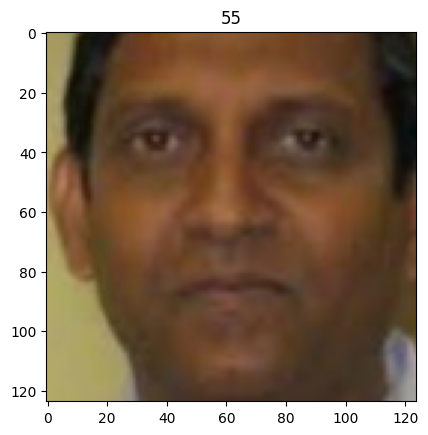

In [ ]:
plt.imshow(df['Images'][0])
plt.title(df['Ages'][0])
plt.show()

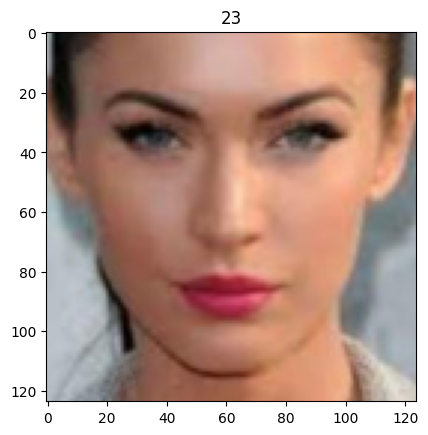

In [ ]:
plt.imshow(df['Images'][1])
plt.title(df['Ages'][1])
plt.show()

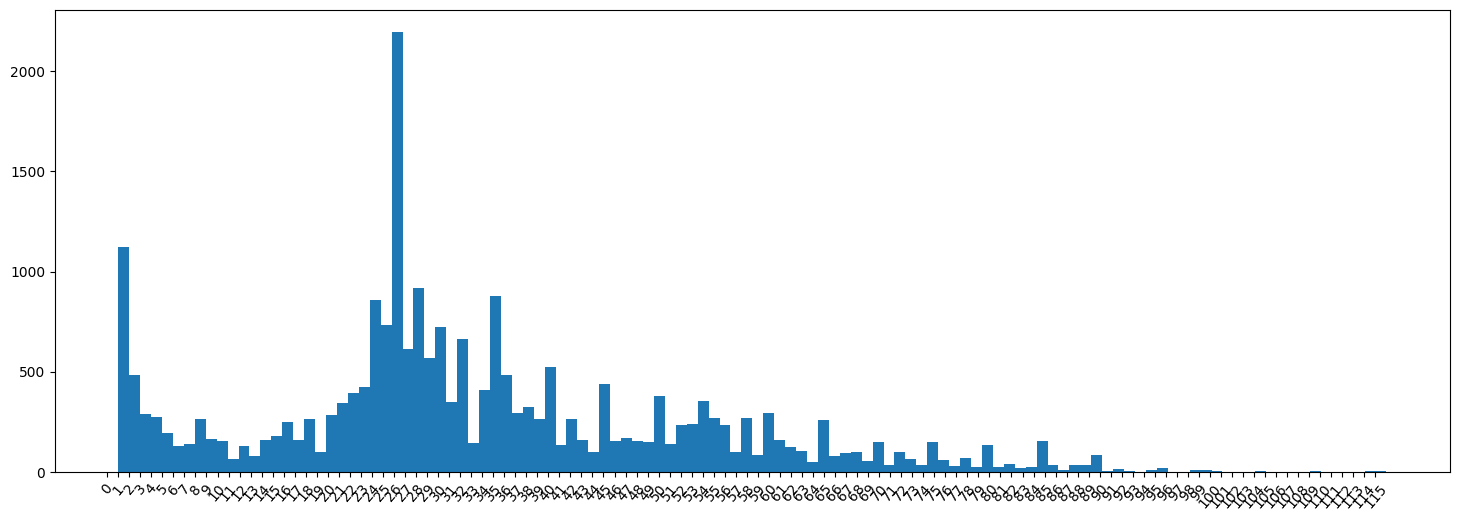

In [ ]:
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], df['Ages'].max())
plt.xticks(range(max(df['Ages'])), rotation=50)
plt.show()

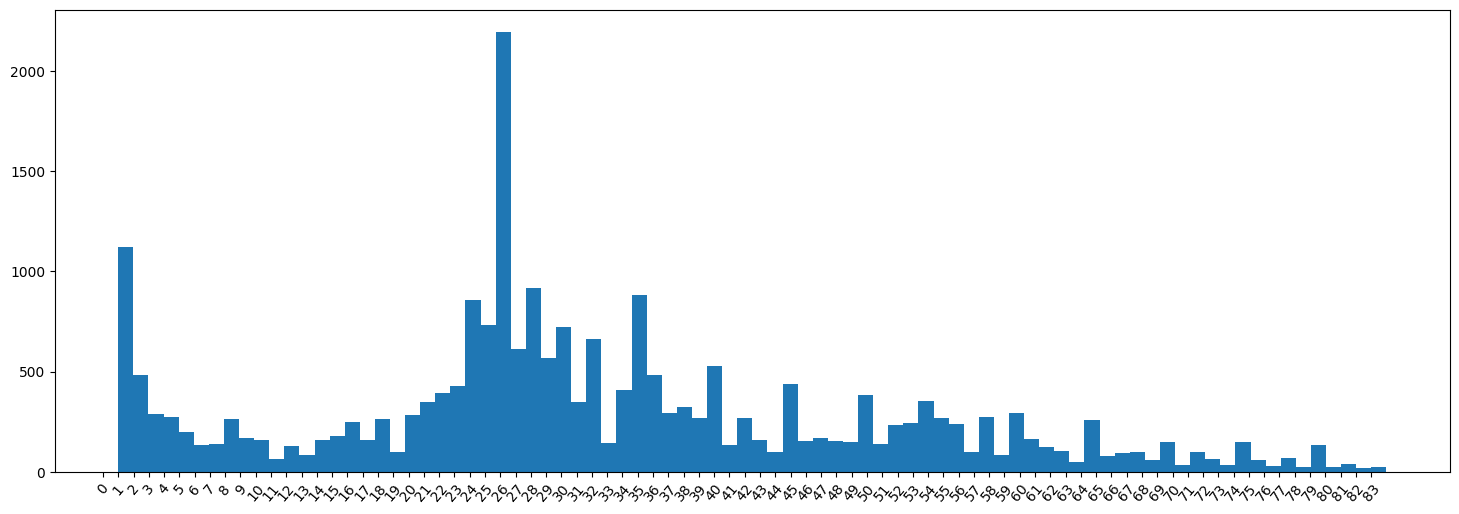

In [ ]:
df = df[df['Ages'] < 85]
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], df['Ages'].max())
plt.xticks(range(max(df['Ages'])), rotation=50)
plt.show()

In [ ]:
df = pd.concat([
    df[(df['Ages'] == 26)].sample(frac=0.3),
    df[(df['Ages'] != 26)]
], axis=0)

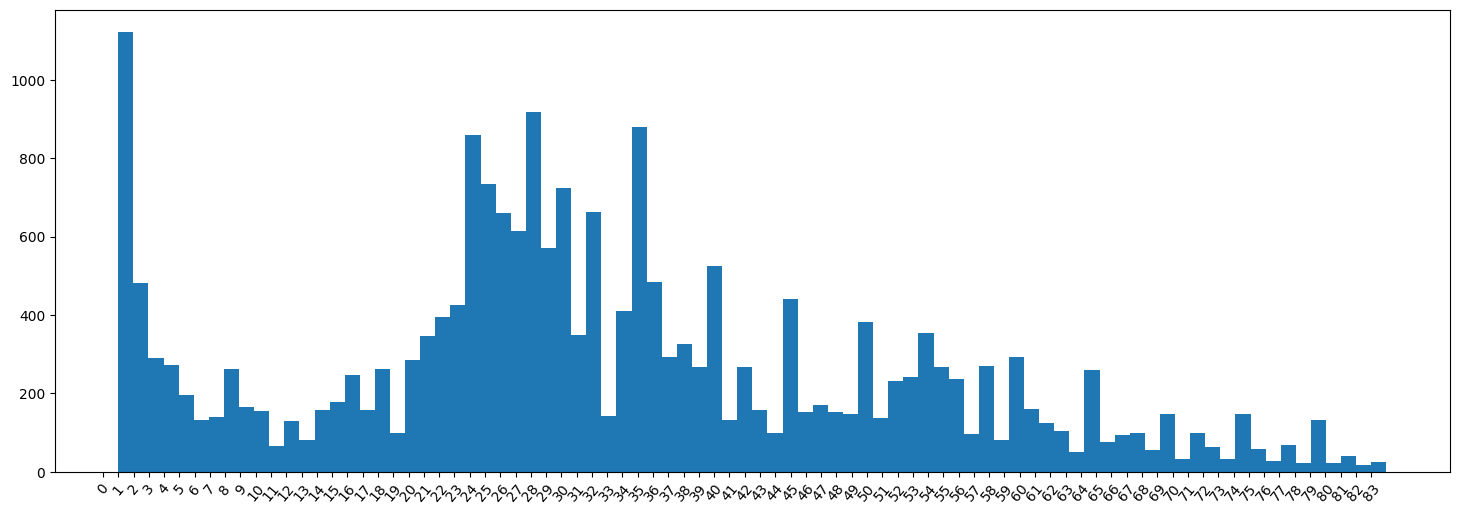

In [ ]:
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], df['Ages'].max())
plt.xticks(range(max(df['Ages'])), rotation=50)
plt.show()

In [ ]:
df = pd.concat([
    df[(df['Ages'] == 1)].sample(frac=.1),
    df[(df['Ages'] != 1)]
], axis=0)

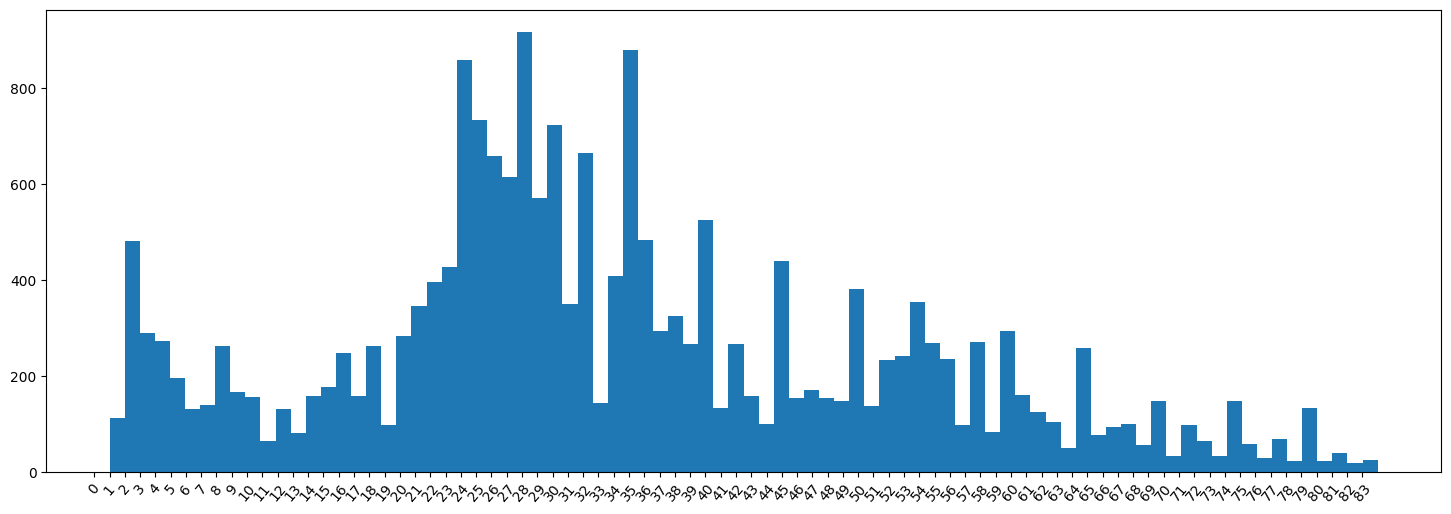

In [ ]:
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], df['Ages'].max())
plt.xticks(range(max(df['Ages'])), rotation=50)
plt.show()

In [ ]:
del images
del ages

In [ ]:
X = np.array(df['Images'].values.tolist())
Y = np.array(df['Ages'].values.tolist())
X.shape, Y.shape

((20723, 124, 124, 3), (20723,))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=.2)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((16578, 124, 124, 3), (4145, 124, 124, 3), (16578,), (4145,))

In [ ]:
del X
del Y

## Create The Model

In [ ]:
idg = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

train_dataset = idg.flow(x_train, y_train)
del x_train
del y_train
validation_dataset = idg.flow(x_val, y_val, batch_size=16, shuffle=False)
del x_val, y_val

In [ ]:
# regnet = RegNetX032(
#     include_top=False,
#     input_shape=INPUT_SHAPE,
# )
# mobilenet = MobileNetV2(
#     include_top=False,
#     input_shape=INPUT_SHAPE,
# )
# resnet = ResNet50V2(
#     include_top=False,
#     input_shape=INPUT_SHAPE
# )
xcetionnet = Xception(
    include_top=False,
    input_shape=INPUT_SHAPE
)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
# for layer in regnet.layers[:15]:
# for layer in mobilenet.layers[:-10]:
for layer in xcetionnet.layers[:-2]:
    layer.trainable = False

In [ ]:
# del model
model: Sequential = Sequential([
    # regnet,
    # mobilenet,
    xcetionnet,
    layers.Dropout(.5, name='DropoutLayer'),
    layers.Dense(1, relu, name='OutputLayer')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 DropoutLayer (Dropout)      (None, 4, 4, 2048)        0         
                                                                 
 OutputLayer (Dense)         (None, 4, 4, 1)           2049      
                                                                 
Total params: 20863529 (79.59 MB)
Trainable params: 6145 (24.00 KB)
Non-trainable params: 20857384 (79.56 MB)
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=Adam(),
    loss=losses.mean_absolute_error
)
checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True)
stop = EarlyStopping(patience=10)

In [ ]:
# del regnet
# del mobilenet
del xcetionnet
history: History = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[stop, checkpoint, wandb_callbacks]
)

Epoch 1/40
518/519 [============================>.] - ETA: 0s - loss: 19.3603

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 55s 94ms/step - loss: 19.3558 - val_loss: 15.9912
Epoch 2/40
518/519 [============================>.] - ETA: 0s - loss: 15.7841

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 44s 85ms/step - loss: 15.7845 - val_loss: 14.8744
Epoch 3/40
518/519 [============================>.] - ETA: 0s - loss: 15.2964

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 45s 86ms/step - loss: 15.2938 - val_loss: 14.5655
Epoch 4/40
518/519 [============================>.] - ETA: 0s - loss: 15.1093

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 49s 95ms/step - loss: 15.1146 - val_loss: 14.4442
Epoch 5/40
518/519 [============================>.] - ETA: 0s - loss: 15.0144

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 49s 95ms/step - loss: 15.0173 - val_loss: 14.4212
Epoch 6/40
519/519 [==============================] - ETA: 0s - loss: 14.9291

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 46s 88ms/step - loss: 14.9291 - val_loss: 14.3059
Epoch 7/40
518/519 [============================>.] - ETA: 0s - loss: 14.8733

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 45s 87ms/step - loss: 14.8703 - val_loss: 14.2981
Epoch 8/40
519/519 [==============================] - ETA: 0s - loss: 14.8238

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 46s 88ms/step - loss: 14.8238 - val_loss: 14.2507
Epoch 9/40
519/519 [==============================] - ETA: 0s - loss: 14.7798

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 46s 88ms/step - loss: 14.7798 - val_loss: 14.2213
Epoch 10/40
519/519 [==============================] - ETA: 0s - loss: 14.7289

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 44s 85ms/step - loss: 14.7289 - val_loss: 14.2226
Epoch 11/40
518/519 [============================>.] - ETA: 0s - loss: 14.7174

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 45s 86ms/step - loss: 14.7204 - val_loss: 14.2213
Epoch 12/40
518/519 [============================>.] - ETA: 0s - loss: 14.6635

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 46s 88ms/step - loss: 14.6659 - val_loss: 14.2108
Epoch 13/40
518/519 [============================>.] - ETA: 0s - loss: 14.6351

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 46s 88ms/step - loss: 14.6328 - val_loss: 14.1268
Epoch 14/40
518/519 [============================>.] - ETA: 0s - loss: 14.5798

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 46s 88ms/step - loss: 14.5818 - val_loss: 14.1068
Epoch 15/40
518/519 [============================>.] - ETA: 0s - loss: 14.5374

wandb: Adding directory to artifact (./models)... Done. 0.4s


519/519 [==============================] - 46s 88ms/step - loss: 14.5367 - val_loss: 14.0915
Epoch 16/40
518/519 [============================>.] - ETA: 0s - loss: 14.4830

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 46s 88ms/step - loss: 14.4829 - val_loss: 14.0614
Epoch 17/40
519/519 [==============================] - ETA: 0s - loss: 14.4670

wandb: Adding directory to artifact (./models)... Done. 4.9s


519/519 [==============================] - 49s 95ms/step - loss: 14.4670 - val_loss: 14.0640
Epoch 18/40
518/519 [============================>.] - ETA: 0s - loss: 14.4479

wandb: Adding directory to artifact (./models)... Done. 3.8s


519/519 [==============================] - 51s 98ms/step - loss: 14.4440 - val_loss: 14.0207
Epoch 19/40
518/519 [============================>.] - ETA: 0s - loss: 14.4081

wandb: Adding directory to artifact (./models)... Done. 0.7s


519/519 [==============================] - 46s 89ms/step - loss: 14.4094 - val_loss: 14.0157
Epoch 20/40
519/519 [==============================] - ETA: 0s - loss: 14.4047

wandb: Adding directory to artifact (./models)... Done. 5.1s


519/519 [==============================] - 51s 98ms/step - loss: 14.4047 - val_loss: 14.0052
Epoch 21/40
519/519 [==============================] - ETA: 0s - loss: 14.3750

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 45s 87ms/step - loss: 14.3750 - val_loss: 13.9978
Epoch 22/40
518/519 [============================>.] - ETA: 0s - loss: 14.3634

wandb: Adding directory to artifact (./models)... Done. 0.4s


519/519 [==============================] - 45s 86ms/step - loss: 14.3672 - val_loss: 14.0046
Epoch 23/40
518/519 [============================>.] - ETA: 0s - loss: 14.3601

wandb: Adding directory to artifact (./models)... Done. 1.9s


519/519 [==============================] - 50s 96ms/step - loss: 14.3628 - val_loss: 14.0709
Epoch 24/40
519/519 [==============================] - ETA: 0s - loss: 14.3470

wandb: Adding directory to artifact (./models)... Done. 0.3s


519/519 [==============================] - 46s 88ms/step - loss: 14.3470 - val_loss: 13.9922
Epoch 25/40
518/519 [============================>.] - ETA: 0s - loss: 14.3367

wandb: Adding directory to artifact (./models)... Done. 2.2s


519/519 [==============================] - 46s 90ms/step - loss: 14.3394 - val_loss: 14.0406
Epoch 26/40
518/519 [============================>.] - ETA: 0s - loss: 14.3220

wandb: Adding directory to artifact (./models)... Done. 4.8s


519/519 [==============================] - 49s 94ms/step - loss: 14.3267 - val_loss: 14.0990
Epoch 27/40
519/519 [==============================] - ETA: 0s - loss: 14.3350

wandb: Adding directory to artifact (./models)... Done. 0.4s


519/519 [==============================] - 45s 86ms/step - loss: 14.3350 - val_loss: 14.1220
Epoch 28/40
518/519 [============================>.] - ETA: 0s - loss: 14.3262

wandb: Adding directory to artifact (./models)... Done. 0.5s


519/519 [==============================] - 44s 86ms/step - loss: 14.3232 - val_loss: 14.0287
Epoch 29/40
518/519 [============================>.] - ETA: 0s - loss: 14.3157

wandb: Adding directory to artifact (./models)... Done. 1.2s


519/519 [==============================] - 47s 90ms/step - loss: 14.3168 - val_loss: 13.9873
Epoch 30/40
519/519 [==============================] - ETA: 0s - loss: 14.3145

wandb: Adding directory to artifact (./models)... Done. 0.6s


519/519 [==============================] - 46s 89ms/step - loss: 14.3145 - val_loss: 13.9861
Epoch 31/40
518/519 [============================>.] - ETA: 0s - loss: 14.3099

wandb: Adding directory to artifact (./models)... Done. 4.6s


519/519 [==============================] - 49s 95ms/step - loss: 14.3147 - val_loss: 14.0028
Epoch 32/40
518/519 [============================>.] - ETA: 0s - loss: 14.3042

wandb: Adding directory to artifact (./models)... Done. 3.7s


519/519 [==============================] - 49s 95ms/step - loss: 14.3071 - val_loss: 13.9792
Epoch 33/40
519/519 [==============================] - ETA: 0s - loss: 14.2982

wandb: Adding directory to artifact (./models)... Done. 3.4s


519/519 [==============================] - 48s 92ms/step - loss: 14.2982 - val_loss: 13.9969
Epoch 34/40
519/519 [==============================] - ETA: 0s - loss: 14.3035

wandb: Adding directory to artifact (./models)... Done. 2.8s


519/519 [==============================] - 47s 91ms/step - loss: 14.3035 - val_loss: 13.9872
Epoch 35/40
518/519 [============================>.] - ETA: 0s - loss: 14.3009

wandb: Adding directory to artifact (./models)... Done. 0.6s


519/519 [==============================] - 44s 85ms/step - loss: 14.3014 - val_loss: 13.9844
Epoch 36/40
518/519 [============================>.] - ETA: 0s - loss: 14.3024

wandb: Adding directory to artifact (./models)... Done. 1.9s


519/519 [==============================] - 46s 89ms/step - loss: 14.3003 - val_loss: 13.9840
Epoch 37/40
519/519 [==============================] - ETA: 0s - loss: 14.2977

wandb: Adding directory to artifact (./models)... Done. 0.8s


519/519 [==============================] - 45s 87ms/step - loss: 14.2977 - val_loss: 13.9877
Epoch 38/40
519/519 [==============================] - ETA: 0s - loss: 14.2904

wandb: Adding directory to artifact (./models)... Done. 2.0s


519/519 [==============================] - 47s 90ms/step - loss: 14.2904 - val_loss: 13.9930
Epoch 39/40
519/519 [==============================] - ETA: 0s - loss: 14.2873

wandb: Adding directory to artifact (./models)... Done. 0.9s


519/519 [==============================] - 45s 87ms/step - loss: 14.2873 - val_loss: 13.9805
Epoch 40/40
519/519 [==============================] - ETA: 0s - loss: 14.2843

wandb: Adding directory to artifact (./models)... Done. 1.0s


519/519 [==============================] - 49s 94ms/step - loss: 14.2843 - val_loss: 13.9830


In [ ]:
del model
del train_dataset
model: Sequential = load_model(MODEL_SAVE_PATH)
model.evaluate(validation_dataset)

260/260 [==============================] - 11s 24ms/step - loss: 14.3656


14.365639686584473

In [ ]:
del validation_dataset

## Inference

In [ ]:
model: Sequential = load_model(MODEL_SAVE_PATH)

In [ ]:
def predict(model_path: str, test_image_path: str) -> float:
    faces = RetinaFace.extract_faces(img_path=test_image_path, align=True)
    img = faces[0]
    img = cv.resize(img, INPUT_SHAPE[:2])

    plt.imshow(img)

    img = img / 255.
    img = np.expand_dims(img, axis=0)

    return model.predict(img)[0]

In [ ]:
!wget https://fcb-abj-pre.s3.amazonaws.com/img/jugadors/MESSI.jpg

--2024-02-11 10:04:13--  https://fcb-abj-pre.s3.amazonaws.com/img/jugadors/MESSI.jpg
Resolving fcb-abj-pre.s3.amazonaws.com (fcb-abj-pre.s3.amazonaws.com)... 52.218.62.162, 52.92.1.161, 52.218.61.138, ...
Connecting to fcb-abj-pre.s3.amazonaws.com (fcb-abj-pre.s3.amazonaws.com)|52.218.62.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107778 (105K) [application/octet-stream]
Saving to: ‘MESSI.jpg’

MESSI.jpg           100%[===================>] 105.25K   507KB/s    in 0.2s    

2024-02-11 10:04:13 (507 KB/s) - ‘MESSI.jpg’ saved [107778/107778]



1/1 [==============================] - 0s 36ms/step
Age predicted: [31.92949]


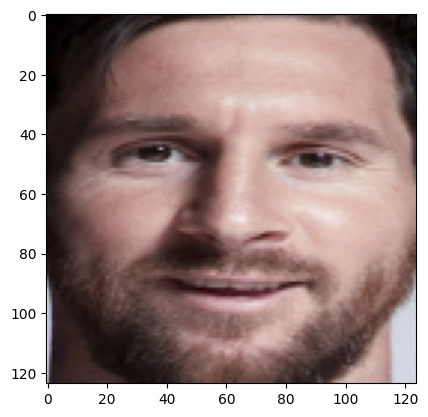

In [ ]:
age = predict(MODEL_SAVE_PATH, '/content/MESSI.jpg')
print(f'Age predicted: {age[0][0]}')